<a href="https://colab.research.google.com/github/fraco03/6D_pose/blob/pose_rgb/notebooks/pose_rgb/pose_rgb_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import sys

# Clone or pull part
repo_url = "https://github.com/fraco03/6D_pose.git"
repo_dir = "/content/6D_pose"   #Modify here for kaggle
branch = "pose_rgb"

# Clone if missing
if not os.path.exists(repo_dir):
    !git clone -b {branch} {repo_url}
    print(f"Cloned {repo_url} to {repo_dir}")
else:
    %cd {repo_dir}
    !git fetch origin
    !git checkout {branch}
    !git reset --hard origin/{branch}
    %cd ..
    print(f"Updated {repo_url} to {repo_dir}")

# Add repository to Python path
if repo_dir not in sys.path:
    sys.path.insert(0, repo_dir)


/content/6D_pose
Already on 'pose_rgb'
Your branch is up to date with 'origin/pose_rgb'.
HEAD is now at 53f9b3e Fixed inference on pose rgb
/content
Updated https://github.com/fraco03/6D_pose.git to /content/6D_pose


In [8]:
from google.colab import drive
from utils.load_data import mount_drive

# Mounting part
mount_drive()

dataset_root = "/content/drive/MyDrive/Linemod_preprocessed" #Modify here for kaggle

print("\n✅ Setup complete!")
print(f"📁 Dataset path: {dataset_root}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted at /content/drive

✅ Setup complete!
📁 Dataset path: /content/drive/MyDrive/Linemod_preprocessed


In [10]:
!pip install plyfile
from utils.projection_utils import *

setup_projection_utils(dataset_root)

In [11]:
from src.pose_rgb.model import ResNetRotation, TranslationNet
import torch

model_path = "/content/drive/MyDrive/runs/20251216_120636/best_model.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"



best_models = torch.load(model_path, map_location=torch.device(device))

best_models.keys()

model_rot = ResNetRotation()
model_rot.load_state_dict(best_models["model_rot"])
model_trans = TranslationNet()
model_trans.load_state_dict(best_models["model_trans"]);


🔒 ResNet backbone frozen.


In [12]:
from src.pose_rgb.dataset import LineModPoseDataset

test_dataset = LineModPoseDataset(dataset_root, "test")

 Loaded LineModPoseDataset
   Split: test
   Dir : [1, 2, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
   Total samples: 20528


In [27]:
sample = test_dataset[10012]

img = sample['image'].unsqueeze(0).to(device)
bbox_info = sample["bbox_info"].unsqueeze(0).to(device)
bbox_center = sample["bbox_center"].unsqueeze(0).to(device)
gt_rot = sample["rotation"].to(device)
gt_trans = sample["translation"].to(device)  # In metri
cam_K = sample["cam_K"].unsqueeze(0).to(device)  # In millimetri

# Set models to evaluation mode
model_rot.eval()
model_trans.eval()

# Forward pass
pred_rot = model_rot(img)
pred_trans_raw = model_trans(img, bbox_info)

# Conversione predizioni: [dx, dy, log(z)] -> [X, Y, Z] in metri
from src.pose_rgb.pose_utils import inverse_pinhole_projection

pred_dx_dy = pred_trans_raw[:, :2]
pred_z_log = pred_trans_raw[:, 2]
pred_z_m = torch.exp(pred_z_log)

# Converti z in mm per la pinhole projection (cam_K è in mm)
pred_z_mm = pred_z_m * 1000.0

# Calcola X, Y, Z in mm usando la geometria pinhole
pred_3d_mm = inverse_pinhole_projection(
    crop_center=bbox_center,
    deltas=pred_dx_dy,
    z=pred_z_mm,
    cam_K=cam_K
)

# Converti in metri per la predizione finale
pred_trans = pred_3d_mm / 1000.0

In [28]:
print("Rotation:")
print(f"  Predicted: {pred_rot.squeeze(0).detach().cpu().numpy()}")
print(f"  GT:        {gt_rot.detach().cpu().numpy()}")
print("\nTranslation (meters):")
print(f"  Predicted: {pred_trans.squeeze(0).detach().cpu().numpy()}")
print(f"  GT:        {gt_trans.detach().cpu().numpy()}")

Rotation:
  Predicted: [-0.14961636 -0.9603767   0.23035592 -0.04719766]
  GT:        [ 0.52977985  0.6193329  -0.53742856  0.21663466]

Translation (meters):
  Predicted: [-0.0740281   0.03576308  0.9123778 ]
  GT:        [-0.05294309  0.01585912  0.82310975]


In [29]:
sim = torch.dot(pred_rot.squeeze(0), gt_rot)
angle = 2 * torch.acos(torch.abs(sim))
print(sim, angle)

tensor(-0.8081, grad_fn=<DotBackward0>) tensor(1.2598, grad_fn=<MulBackward0>)


GT Translation (m):   [-0.05294309  0.01585912  0.82310975]
Pred Translation (m): [-0.0740281   0.03576308  0.9123778 ]
Error (m):            [0.02108501 0.01990396 0.08926803]


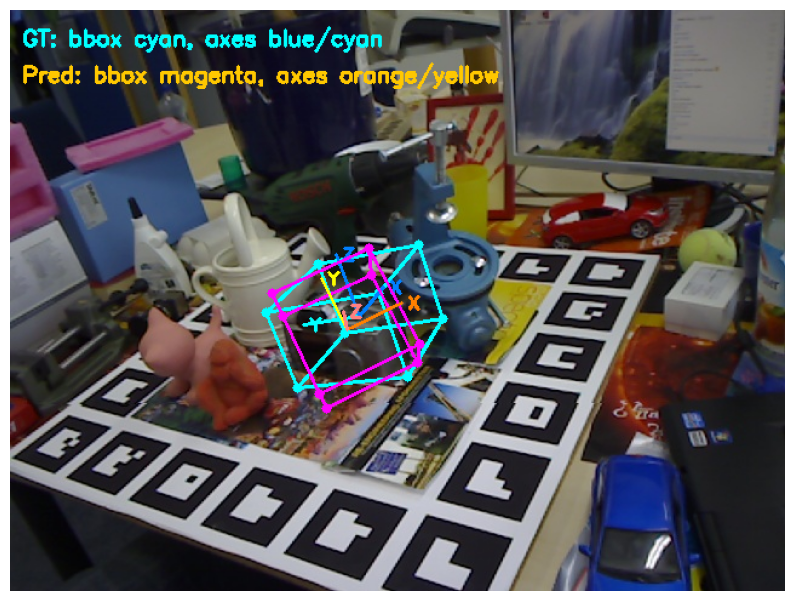

In [31]:
import matplotlib.pyplot as plt
import numpy as np

full_image = get_image_from_sample(sample)
object_id = sample['object_id']

# GT in numpy (già in metri)
gt_rotation_np = sample['rotation'].detach().cpu().numpy()
gt_translation_np = sample['translation'].detach().cpu().numpy()

# Predizione in numpy (già in metri dopo le conversioni)
pred_rotation_np = pred_rot.squeeze(0).detach().cpu().numpy()
pred_translation_np = pred_trans.squeeze(0).detach().cpu().numpy()

print(f"GT Translation (m):   {gt_translation_np}")
print(f"Pred Translation (m): {pred_translation_np}")
print(f"Error (m):            {np.abs(gt_translation_np - pred_translation_np)}")

# Visualizza le pose
plt.figure(figsize=(10, 10))
plt.imshow(visualize_pose_comparison(
    full_image, object_id, cam_K.squeeze(0),
    gt_rotation_np, gt_translation_np,
    pred_rotation_np, pred_translation_np
))
plt.axis('off')
plt.show()

---
## Evaluation Framework

Valutiamo il modello su un subset del test set calcolando metriche ADD/ADD-S.

In [ ]:
from utils.linemod_config import get_linemod_config
from metrics.ADD_metric import compute_ADD_metric_quaternion, compute_ADD_S_metric_quaternion

# Oggetti simmetrici LineMOD
SYMMETRIC_OBJECTS = [10, 11]  # Eggbox e Glue

def is_symmetric(obj_id):
    return obj_id in SYMMETRIC_OBJECTS

# Load config
config = get_linemod_config(dataset_root)

print("✅ Evaluation functions loaded")

In [ ]:
from tqdm import tqdm
import pandas as pd

# Evaluate on multiple samples
num_samples = 100  # Adjust based on test set size
results = []

print(f"📊 Evaluating {num_samples} samples from test set...")

for i in tqdm(range(min(num_samples, len(test_dataset)))):
    sample = test_dataset[i]
    image = sample['image'].unsqueeze(0).to(device)
    bbox_info = sample['bbox_info'].unsqueeze(0).to(device)
    bbox_center = sample['bbox_center'].unsqueeze(0).to(device)
    cam_K = sample['cam_K'].unsqueeze(0).to(device)
    
    gt_quat = sample['quaternion'].numpy()
    gt_translation = sample['translation'].numpy()
    obj_id = sample['obj_id']
    model_points = config[f'{obj_id:02d}']['pts'] / 1000.0  # mm to meters
    
    # Predict
    with torch.no_grad():
        pred_rotation = model_rot(image)
        pred_trans_raw = model_trans(image, bbox_info)
        
        # Convert predictions to 3D translation (meters)
        pred_dx_dy = pred_trans_raw[:, :2]
        pred_log_z = pred_trans_raw[:, 2]
        pred_z_m = torch.exp(pred_log_z)
        pred_z_mm = pred_z_m * 1000.0
        
        pred_3d_mm = inverse_pinhole_projection(
            pred_dx_dy[:, 0], pred_dx_dy[:, 1], pred_z_mm, bbox_center, cam_K
        )
        pred_3d_m = pred_3d_mm / 1000.0
        
        pred_quat = pred_rotation.squeeze(0).cpu().numpy()
        pred_translation = pred_3d_m.squeeze(0).cpu().numpy()
    
    # Compute metrics
    symmetric = is_symmetric(obj_id)
    
    if symmetric:
        add_error = compute_ADD_S_metric_quaternion(
            model_points, gt_quat, gt_translation, pred_quat, pred_translation
        )
        metric_name = 'ADD-S'
    else:
        add_error = compute_ADD_metric_quaternion(
            model_points, gt_quat, gt_translation, pred_quat, pred_translation
        )
        metric_name = 'ADD'
    
    # Translation error
    trans_error = np.linalg.norm(gt_translation - pred_translation)
    
    # Rotation error (quaternion distance)
    from src.pose_rgb.pose_utils import quaternion_to_rotation_matrix
    R_gt = quaternion_to_rotation_matrix(torch.from_numpy(gt_quat).float()).numpy()
    R_pred = quaternion_to_rotation_matrix(torch.from_numpy(pred_quat).float()).numpy()
    
    trace = np.trace(R_gt.T @ R_pred)
    rot_error_deg = np.degrees(np.arccos(np.clip((trace - 1) / 2, -1, 1)))
    
    results.append({
        'sample_idx': i,
        'obj_id': obj_id,
        'symmetric': symmetric,
        'metric_name': metric_name,
        'add_error': add_error,
        'trans_error': trans_error,
        'rot_error_deg': rot_error_deg,
        'diameter': config[f'{obj_id:02d}']['diameter'] / 1000.0  # mm to meters
    })

# Convert to DataFrame
df = pd.DataFrame(results)
print(f"\n✅ Evaluation complete! {len(results)} samples processed")

### Overall Statistics

In [ ]:
# Overall metrics
print("=" * 60)
print("📊 OVERALL METRICS (RGB Model)")
print("=" * 60)
print(f"Mean ADD Error:        {df['add_error'].mean()*1000:.2f} mm")
print(f"Median ADD Error:      {df['add_error'].median()*1000:.2f} mm")
print(f"Std ADD Error:         {df['add_error'].std()*1000:.2f} mm")
print(f"\nMean Translation Error: {df['trans_error'].mean()*1000:.2f} mm")
print(f"Mean Rotation Error:    {df['rot_error_deg'].mean():.2f}°")
print()

# Success rates (ADD < 10% diameter threshold)
df['add_success'] = df['add_error'] < (0.1 * df['diameter'])
print(f"ADD < 10% diameter:    {df['add_success'].mean()*100:.1f}%")
print("=" * 60)

### Per-Object Statistics

In [ ]:
# Group by object
obj_stats = df.groupby('obj_id').agg({
    'add_error': ['mean', 'std', 'count'],
    'trans_error': 'mean',
    'rot_error_deg': 'mean',
    'add_success': 'mean'
}).round(4)

print("\n" + "=" * 80)
print("📦 PER-OBJECT STATISTICS")
print("=" * 80)
print(f"{'Obj':<5} {'Sym':<5} {'Samples':<10} {'ADD (mm)':<15} {'Trans (mm)':<15} {'Rot (°)':<12} {'Success %':<10}")
print("-" * 80)

for obj_id in sorted(df['obj_id'].unique()):
    obj_data = df[df['obj_id'] == obj_id]
    sym_mark = '✓' if is_symmetric(obj_id) else ''
    
    count = len(obj_data)
    add_mean = obj_data['add_error'].mean() * 1000
    add_std = obj_data['add_error'].std() * 1000
    trans_mean = obj_data['trans_error'].mean() * 1000
    rot_mean = obj_data['rot_error_deg'].mean()
    success_rate = obj_data['add_success'].mean() * 100
    
    print(f"{obj_id:<5} {sym_mark:<5} {count:<10} {add_mean:.2f}±{add_std:.2f} mm {trans_mean:>10.2f} mm {rot_mean:>10.2f}° {success_rate:>9.1f}%")

print("=" * 80)

### Error Distributions

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# ADD error distribution
axes[0].hist(df['add_error'] * 1000, bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(df['add_error'].mean() * 1000, color='red', linestyle='--', 
                label=f'Mean: {df["add_error"].mean()*1000:.2f} mm')
axes[0].set_xlabel('ADD Error (mm)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('ADD Error Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Translation error distribution
axes[1].hist(df['trans_error'] * 1000, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(df['trans_error'].mean() * 1000, color='red', linestyle='--',
                label=f'Mean: {df["trans_error"].mean()*1000:.2f} mm')
axes[1].set_xlabel('Translation Error (mm)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Translation Error Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Rotation error distribution
axes[2].hist(df['rot_error_deg'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[2].axvline(df['rot_error_deg'].mean(), color='red', linestyle='--',
                label=f'Mean: {df["rot_error_deg"].mean():.2f}°')
axes[2].set_xlabel('Rotation Error (degrees)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Rotation Error Distribution')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Best and Worst Predictions

In [ ]:
# Find best and worst predictions
best_idx = df['add_error'].idxmin()
worst_idx = df['add_error'].idxmax()

print(f"🏆 Best prediction (sample {best_idx}):")
print(f"   ADD Error: {df.loc[best_idx, 'add_error']*1000:.2f} mm")
print(f"   Object: {df.loc[best_idx, 'obj_id']}")
print()
print(f"❌ Worst prediction (sample {worst_idx}):")
print(f"   ADD Error: {df.loc[worst_idx, 'add_error']*1000:.2f} mm")
print(f"   Object: {df.loc[worst_idx, 'obj_id']}")